In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.4 MB 10.7 MB/s 
     |████████████████████████████████| 1.8 MB 13.7 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.8 MB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 37.1 MB 46 kB/s 
     |████████████████████████████████| 679 kB 42.7 MB/s 
     |████████████████████████████████| 352 kB 42.9 MB/s 
     |████████████████████████████████| 636 kB 45.1 MB/s 
     |████████████████████████████████| 90 kB 8.8 MB/s 
     |████████████████████████████████| 211 kB 45.3 MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# Download Dataset
We will be using IMDB data for Sentiment Analysis

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 6s 0us/step


create a labeled tf.data.Dataset with 80:20 split from training data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

In [ ]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.


Some samples

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

#Loading model

In [ ]:
# Choosing a model to load
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# Preprocessing Data

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to model. We will be using the preprocessing model which implements this transformation using TF ops from the TF.text library

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Testing the preprocess model

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


"input_mask" The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.

"input_type_ids" only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Each preprocessing model also provides a method, .bert_pack_inputs(tensors, seq_length), which takes a list of tokens (like tok above) and a sequence length argument. This packs the inputs to create a dictionary of tensors in the format expected by the BERT model.

In [ ]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids :  (1, 20)
Word Ids       :  tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 20)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 20)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


# Trying BERT pretrained model

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626282   0.9928099  -0.18611862  0.3667383   0.15233758  0.655044
  0.9681154  -0.94862705  0.0021616  -0.9877732   0.06842764 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946292  0.34321183  0.33231512 ...  0.21300802  0.7102092
  -0.05771042]
 [-0.28741995  0.31980985 -0.23018652 ...  0.5845511  -0.21329862
   0.72692007]
 [-0.6615692   0.68876815 -0.8743301  ...  0.1087728  -0.26173076
   0.47855455]
 ...
 [-0.22561137 -0.2892573  -0.07064426 ...  0.47566032  0.8327724
   0.40025347]
 [-0.2982421  -0.27473164 -0.05450544 ...  0.4884972   1.0955367
   0.18163365]
 [-0.4437818   0.00930662  0.07223704 ...  0.17290089  1.1833239
   0.07897975]]


BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs:

"pooled_output" represents each input sequence as a whole. The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.

"sequence_output" represents each input token in the context. The shape is [batch_size, seq_length, H]. You can think of this as a contextual embedding for every token in the movie review.

"encoder_outputs" are the intermediate activations of the L Transformer blocks. outputs["encoder_outputs"][i] is a Tensor of shape [batch_size, seq_length, 1024] with the outputs of the i-th Transformer block, for 0 <= i < L. The last value of the list is equal to sequence_output.

For the fine-tuning you are going to use the pooled_output array.

# Defining classification model

In [ ]:
def build_classifier_model():
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  encoder_inputs = preprocessing_layer(text_input)
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Test model

In [ ]:
classifier_model = build_classifier_model()

In [ ]:
text_test = ['this is such an amazing movie!']
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.55305433]], shape=(1, 1), dtype=float32)


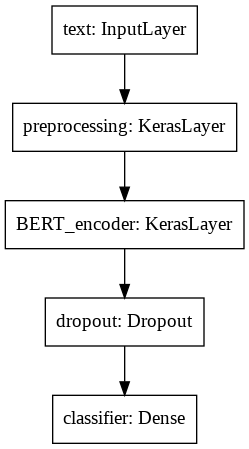

In [ ]:
tf.keras.utils.plot_model(classifier_model)

# Model Training

In [ ]:
epochs = 5
init_lr = 3e-5

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

For the learning rate (init_lr), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps).

In [ ]:
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

AdamW optimizer minimizes the prediction loss and does regularization by weight decay (not using moments).

In [ ]:
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 292s 455ms/step - loss: 0.4939 - binary_accuracy: 0.7354 - val_loss: 0.3838 - val_binary_accuracy: 0.8206
Epoch 2/5
625/625 [==============================] - 278s 445ms/step - loss: 0.3357 - binary_accuracy: 0.8508 - val_loss: 0.3718 - val_binary_accuracy: 0.8420
Epoch 3/5
625/625 [==============================] - 278s 444ms/step - loss: 0.2563 - binary_accuracy: 0.8937 - val_loss: 0.3825 - val_binary_accuracy: 0.8548
Epoch 4/5
625/625 [==============================] - 278s 444ms/step - loss: 0.1920 - binary_accuracy: 0.9242 - val_loss: 0.4313 - val_binary_accuracy: 0.8476
Epoch 5/5
625/625 [==============================] - 278s 444ms/step - loss: 0.1574 - binary_accuracy: 0.9403 - val_loss: 0.4655 - val_binary_accuracy: 0.8504


# Evaluating model

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 153s 196ms/step - loss: 0.4552 - binary_accuracy: 0.8568
Loss: 0.45520031452178955
Accuracy: 0.8568000197410583


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


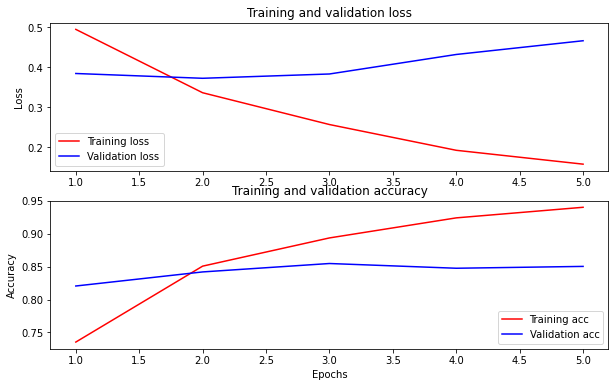

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Export model

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

# Reloading model for Inference

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999374
input: The movie was great!           : score: 0.993030
input: The movie was meh.             : score: 0.830218
input: The movie was okish.           : score: 0.020122
input: The movie was terrible...      : score: 0.001097

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999374
input: The movie was great!           : score: 0.993030
input: The movie was meh.             : score: 0.830218
input: The movie was okish.           : score: 0.020122
input: The movie was terrible...      : score: 0.001097

